<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 3 (Assignment) -- The Vanishing Gradient Problem</h2>

# Exercise 0

- Import the same modules as discussed in the lecture notebook.
- Check if your model versions are correct.

In [31]:
import u3_utils as u3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from functools import partial
from pathlib import Path
from PIL import Image, ImageOps
from scipy import signal
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from torch.utils.data import DataLoader, TensorDataset


In [32]:
u3.check_module_versions()
# same problem as last time. I have python 3.6 but here I got only a cross.


Installed Python version: 3.6 (✗)
Installed numpy version: 1.18.2 (✓)
Installed pandas version: 1.0.3 (✓)
Installed PyTorch version: 1.3.1+cpu (✓)
Installed scikit-learn version: 0.22.2.post1 (✓)
Installed scipy version: 1.4.1 (✓)
Installed matplotlib version: 3.2.0 (✓)
Installed seaborn version: 0.10.0 (✓)
Installed PIL version: 6.2.1 (✓)


# Exercise 1

- Load the Fashion-MNIST dataset.
- Display the first 5 elements of the dataset.
- Create a training and a test dataset (ratio $7:3$)

In [33]:
fashion_mnist_data = u3.load_fashion_mnist()


In [45]:
from torchvision import datasets, transforms
def load_fashion_mnist(flip_probability: float = 0.0):
    transform_composition = transforms.Compose([
        transforms.RandomVerticalFlip(p=flip_probability),
        transforms.ToTensor()
    ])
    return (datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_composition),
            datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_composition))


In [46]:
train_loader, test_loader=load_fashion_mnist()


In [47]:
from typing import List
from torchvision import datasets, transforms

def display_FashionMNIST(images: List[np.ndarray], images_to_show: int = 8) -> None:
    transform_to_PIL = transforms.ToPILImage()
    fig, ax = plt.subplots(nrows=1, ncols=images_to_show, figsize=(9.5, 2))
    for index in range(images_to_show):
        ax[index].axis(r'off')
        ax[index].imshow(transform_to_PIL(images[index][0]), cmap=r'gray')
    fig.tight_layout()
    

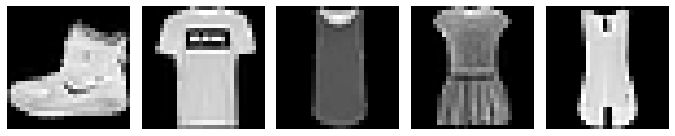

In [48]:
display_FashionMNIST(train_loader, 5)


In [49]:
np.random.seed(42)
fashion_mnist_train, fashion_mnist_test = u3.split_data(fashion_mnist_data, test_size=0.30)


# Interlude (nothing to do here)

We set here the input dimension, the output dimension and the device used for calculation (GPU if available).

In [50]:
input_dim = 784
output_dim = 10
target_device = torch.device(r'cuda' if torch.cuda.is_available() else r'cpu')

We create a dataloader for the training and for the test data set:

In [51]:
image_width = int(np.sqrt(len(fashion_mnist_train.iloc[0])))

# Create instance of Dataloader (training set).
fashion_mnist_loader_train = DataLoader(TensorDataset(
    torch.from_numpy(fashion_mnist_train.drop(columns=[r'item_type']).values.astype(
        dtype=np.float32)).unsqueeze(1).reshape(len(fashion_mnist_train), 1, image_width, image_width),
    torch.from_numpy(fashion_mnist_train[r'item_type'].values.astype(dtype=np.long))
), batch_size=128, shuffle=True, drop_last=False)

# Create instance of Dataloader (test set).
fashion_mnist_loader_test = DataLoader(TensorDataset(
    torch.from_numpy(fashion_mnist_test.drop(columns=[r'item_type']).values.astype(
        dtype=np.float32)).unsqueeze(1).reshape(len(fashion_mnist_test), 1, image_width, image_width),
    torch.from_numpy(fashion_mnist_test[r'item_type'].values.astype(dtype=np.long))
), batch_size=128, shuffle=False, drop_last=False)

# Exercise 2

- Create a logistic regression module.
- Use the <code>nn.Sequential</code> container.
- Run your neural network on the complete Fashion-MNIST dataset for $5$ epochs.
- Report your results on the training set after each epoch.
- Run you final model on the test set, also report you results.

In [52]:
class logistic_regression(nn.Module):
    def __init__(self, D_in, D_out):
        super(logistic_regression, self).__init__()
        
        # your sequential code goes here
        self.model = nn.Sequential(nn.Linear(D_in, D_out, bias=True))
        
    def forward(self, x):
        # your forward pass goes here
        return self.model(x)
    

In [53]:
logistic_regression_model = logistic_regression(input_dim, output_dim).to(target_device)


In [54]:
np.random.seed(42)
torch.manual_seed(42)

optimizer = optim.SGD(logistic_regression_model.parameters(), lr=1e-4, momentum=0.5)
num_epochs = 5
for epoch in range(num_epochs):
    
    # Train LR for one epoch.
    _ = u3.train_network(model=logistic_regression_model, data_loader=fashion_mnist_loader_train,
                     device=target_device, optimizer=optimizer)
    
    # Evaluate current LR model on training data set.
    performance = u3.test_network(
        model=logistic_regression_model, data_loader=fashion_mnist_loader_train, device=target_device)
    
    # Print result of current epoch to standard out.
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Loss: {performance[0]:.4f} / Accuracy: {performance[1]:.4f}')
    
# Evaluate final model on test data set.
performance = u3.test_network(
    model=logistic_regression_model, data_loader=fashion_mnist_loader_test, device=target_device)
print(f'\nFinal loss: {performance[0]:.4f} / Final accuracy: {performance[1]:.4f}')


Epoch: 1 / Loss: 0.1057 / Accuracy: 0.7656
Epoch: 2 / Loss: 0.0614 / Accuracy: 0.8011
Epoch: 3 / Loss: 0.0738 / Accuracy: 0.7962
Epoch: 4 / Loss: 0.0456 / Accuracy: 0.8338
Epoch: 5 / Loss: 0.0793 / Accuracy: 0.7671

Final loss: 0.0846 / Final accuracy: 0.7593


The model reaches a good accuracy.

# Exercise 3

- Implement the following neural network architecture: <br>
1) Input layer $784 \rightarrow 512$  ($\tanh$ activation function) <br>
2) $5$ hidden layers $512 \rightarrow 512$ ($\tanh$ activation function) <br>
3) Output layer $512 \rightarrow 10$ <br>

- Print out your network architecture.
- Run your neural network on the complete Fashion-MNIST dataset for $5$ epochs.
- Report your results on the training set after each epoch.
- Run you final model on the test set, also report you results.
- Plot the gradients in the hidden layers (and the input layer).

In [55]:
import torch.nn as nn
class neural_network_tanh(nn.Module):
    def __init__(self, D_in, D_out):
        super(neural_network_tanh, self).__init__()
        
        # your sequential code goes here
        self.model = nn.Sequential(
            nn.Linear(D_in, 512, bias=True),
            nn.Tanh(),
            nn.Linear(512, 512, bias=True),
            nn.Tanh(),
            nn.Linear(512, 512, bias=True),
            nn.Tanh(),
            nn.Linear(512, 512, bias=True),
            nn.Tanh(),
            nn.Linear(512, 512, bias=True),
            nn.Tanh(),
            nn.Linear(512, 512, bias=True),
            nn.Tanh(),
            nn.Linear(512, D_out, bias=True)
        )      
    def forward(self, x):
        return self.model(x)
    

In [56]:
neural_network_model_tanh = neural_network_tanh(input_dim, output_dim).to(target_device)


In [57]:
neural_network_model_tanh


neural_network_tanh(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Tanh()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): Tanh()
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): Tanh()
    (10): Linear(in_features=512, out_features=512, bias=True)
    (11): Tanh()
    (12): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [58]:
np.random.seed(42)
torch.manual_seed(42)

optimizer = optim.SGD(neural_network_model_tanh.parameters(), lr=1e-3, momentum=0.5)

num_epochs = 5
for epoch in range(num_epochs):
    
    # Train LR for one epoch.
    _ = u3.train_network(model=neural_network_model_tanh, data_loader=fashion_mnist_loader_train,
                     device=target_device, optimizer=optimizer)
    
    # Evaluate current LR model on training data set.
    performance = u3.test_network(
        model=neural_network_model_tanh, data_loader=fashion_mnist_loader_train, device=target_device)
    
    # Print result of current epoch to standard out.
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Loss: {performance[0]:.4f} / Accuracy: {performance[1]:.4f}')
    
# Evaluate final model on test data set.
performance = u3.test_network(
    model=neural_network_model_tanh, data_loader=fashion_mnist_loader_test, device=target_device)
print(f'\nFinal loss: {performance[0]:.4f} / Final accuracy: {performance[1]:.4f}')


Epoch: 1 / Loss: 0.0166 / Accuracy: 0.4876
Epoch: 2 / Loss: 0.0129 / Accuracy: 0.4557
Epoch: 3 / Loss: 0.0106 / Accuracy: 0.5542
Epoch: 4 / Loss: 0.0090 / Accuracy: 0.6014
Epoch: 5 / Loss: 0.0077 / Accuracy: 0.6506

Final loss: 0.0078 / Final accuracy: 0.6466


The accuracy is worse than in Exercise 2. 

In [59]:
from scipy.signal import savgol_filter
def plt_gradients(gradients: list) -> None:
    """
    Plots the gradients of every hidden layer. The gradients of the last layer are not plotted since
    they are usually much larger.

    :param gradients: list of gradients (per layer) to be plotted
    :return: None
    """
    plt.figure(figsize=(10, 8))
    cmap = ['m', 'orange', 'c', 'b', 'g', 'k']
    lmap = ["Input layer", "First hidden layer", "Second hidden layer", "Third hidden layer", "Fourth hidden layer",
            "Fifth hidden layer", "Sixth hidden layer"]
    for index in range(len(gradients)):
        try:
            plt.plot(np.array(gradients[index]), '-', color=cmap[index], label='', alpha=0.15)
            savgol = savgol_filter(np.array(gradients[index]), 25, 3)
            plt.plot(savgol, color=cmap[index], label=lmap[index], alpha=0.75)
        except AttributeError as err:
            print(f'Attribute error: {err}')
            print("Can only plot 6 hidden layers")
            raise
    plt.title('Magnitudes of gradients', fontsize=20)
    plt.legend(loc='best', fontsize=12)
    plt.show()
    

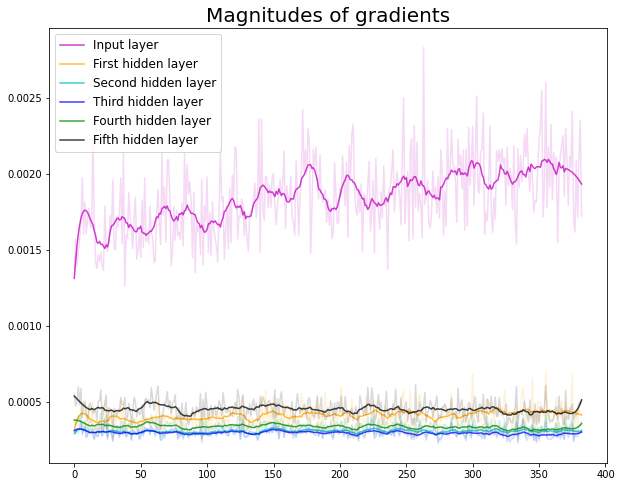

In [60]:
plt_gradients(_)


# Exercise 4

- Plot the $\tanh$ activation function and its derivative: <br>
1) Write a function which returns the tanh for arbitrary input values. <br>
2) Write a function which returns the derivative of the tanh for arbitrary input values. <br>
3) Plot them together.

In [61]:
def tanh(x):
    # your code goes here
    a = np.e ** (2*x) - 1 
    b = np.e ** (2*x) + 1
    c = a / b
    return c 

def dtanh(x):
    # your code goes here
    a = np.e ** (2*x) - 1 
    b = np.e ** (2*x) + 1
    c = (a / b) ** 2
    return 1 - c

def plt_activation_tanh():
    X = np.linspace(-5, 5, 100)

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # your code goes here
    plt.plot(X, tanh(X), color="#307EC7", linewidth=3, label='tanh')
    plt.plot(X, dtanh(X), color="#accbe8", linewidth=3, label='derivative of tanh')
    plt.locator_params(axis='y', nbins=6)
    plt.title('tanh function', fontsize=20)
    plt.legend(prop={'size': 15})
    plt.show()
    

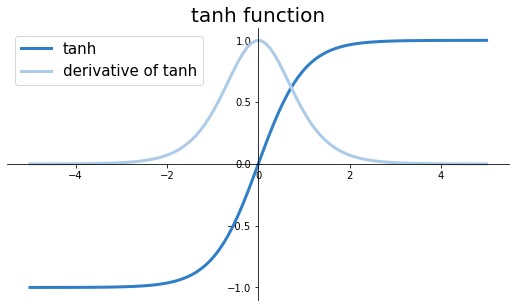

In [62]:
plt_activation_tanh()


# Exercise 5

- Plot the $\text{selu}$ activation function and its derivative: <br>
1) Write a function which returns $\text{selu}(x)$ for arbitrary input values $x$. <br>
2) Write a function which returns the derivative of $\text{selu}(x)$ for arbitrary input values $x$. <br>
3) Plot them together. <br>

- The $\text{selu}$ function is defined as following:
\begin{align*}
selu(x)=\lambda\begin{cases}
    x & \text{if } x\geq 0\\
    \alpha\exp(x)-\alpha              & \text{if } x<0
\end{cases} 
\end{align*}
where $\alpha = 1.6732...$ and $\lambda = 1.0507...$ 

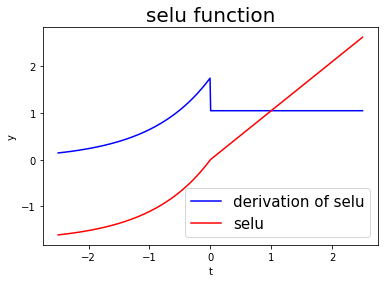

In [63]:
import math
t=np.linspace(-2.5,2.5,500)

def x(i):
    lambda_ = 1.0507
    alpha_ = 1.6732
    if i >= 0:
        i = lambda_ * i
    else:
        i = lambda_ * ((alpha_ * math.exp(i)) - alpha_)
        
    return i

def x_d(i):
    lambda_ = 1.0507
    alpha_ = 1.6732
    if i >= 0:
        i = lambda_
    else:
        i = lambda_ * alpha_ * math.exp(i)
    return i

y2 = []
y = []
for i in t:
    y.append(x(i))
    y2.append(x_d(i))


plt.plot(t,y2, 'blue', label= 'derivation of selu')
plt.plot(t, y, 'red', label= 'selu')
plt.title('selu function', fontsize=20)
plt.legend(prop={'size': 15})
plt.ylabel('y')
plt.xlabel('t')
plt.show()


# Exercise 6

- Repeat the steps of Exercise 3, but use a $\text{selu}$ activation function instead of the $\tanh$ activation function.<br> (Hint: use the nn.SELU() function)

In [69]:
class neural_network_selu(nn.Module):
    def __init__(self, D_in, D_out):
        super(neural_network_selu, self).__init__()
        
         # your sequential code goes here    
        self.model = nn.Sequential(
            nn.Linear(D_in, 512, bias=True),
            nn.SELU(),
            nn.Linear(512, 512, bias=True),
            nn.SELU(),
            nn.Linear(512, 512, bias=True),
            nn.SELU(),
            nn.Linear(512, 512, bias=True),
            nn.SELU(),
            nn.Linear(512, 512, bias=True),
            nn.SELU(),
            nn.Linear(512, 512, bias=True),
            nn.SELU(),
            nn.Linear(512, D_out, bias=True)
        )      
    def forward(self, x):
        # your forward pass goes here
        return self.model(x)
    

In [70]:
neural_network_model_selu = neural_network_selu(input_dim, output_dim).to(target_device)


In [71]:
neural_network_model_selu


neural_network_selu(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): SELU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): SELU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): SELU()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): SELU()
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): SELU()
    (10): Linear(in_features=512, out_features=512, bias=True)
    (11): SELU()
    (12): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [72]:
np.random.seed(42)
torch.manual_seed(42)

optimizer = optim.SGD(neural_network_model_selu.parameters(), lr=1e-3, momentum=0.5)

# your code goes here
num_epochs = 5
for epoch in range(num_epochs):
    
    # Train LR for one epoch.
    _ = u3.train_network(model=neural_network_model_selu, data_loader=fashion_mnist_loader_train,
                     device=target_device, optimizer=optimizer)
    
    # Evaluate current LR model on training data set.
    performance = u3.test_network(
        model=neural_network_model_selu, data_loader=fashion_mnist_loader_train, device=target_device)
    
    # Print result of current epoch to standard out.
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Loss: {performance[0]:.4f} / Accuracy: {performance[1]:.4f}')
    
# Evaluate final model on test data set.
performance = u3.test_network(
    model=neural_network_model_selu, data_loader=fashion_mnist_loader_test, device=target_device)
print(f'\nFinal loss: {performance[0]:.4f} / Final accuracy: {performance[1]:.4f}')


Epoch: 1 / Loss: 0.0039 / Accuracy: 0.8228
Epoch: 2 / Loss: 0.0032 / Accuracy: 0.8560
Epoch: 3 / Loss: 0.0029 / Accuracy: 0.8674
Epoch: 4 / Loss: 0.0028 / Accuracy: 0.8728
Epoch: 5 / Loss: 0.0028 / Accuracy: 0.8683

Final loss: 0.0031 / Final accuracy: 0.8587


The SELU function has an higher positive impact on the accuracy than the tanh function.

In [73]:
def plt_gradients(gradients: list) -> None:
    """
    Plots the gradients of every hidden layer. The gradients of the last layer are not plotted since
    they are usually much larger.

    :param gradients: list of gradients (per layer) to be plotted
    :return: None
    """
    plt.figure(figsize=(10, 8))
    cmap = ['m', 'orange', 'c', 'b', 'g', 'k']
    lmap = ["Input layer", "First hidden layer", "Second hidden layer", "Third hidden layer", "Fourth hidden layer",
            "Fifth hidden layer", "Sixth hidden layer"]
    for index in range(len(gradients)):
        try:
            plt.plot(np.array(gradients[index]), '-', color=cmap[index], label='', alpha=0.15)
            savgol = savgol_filter(np.array(gradients[index]), 25, 3)
            plt.plot(savgol, color=cmap[index], label=lmap[index], alpha=0.75)
        except AttributeError as err:
            print(f'Attribute error: {err}')
            print("Can only plot 6 hidden layers")
            raise
    plt.title('Magnitudes of gradients', fontsize=20)
    plt.legend(loc='best', fontsize=12)
    plt.show()
    

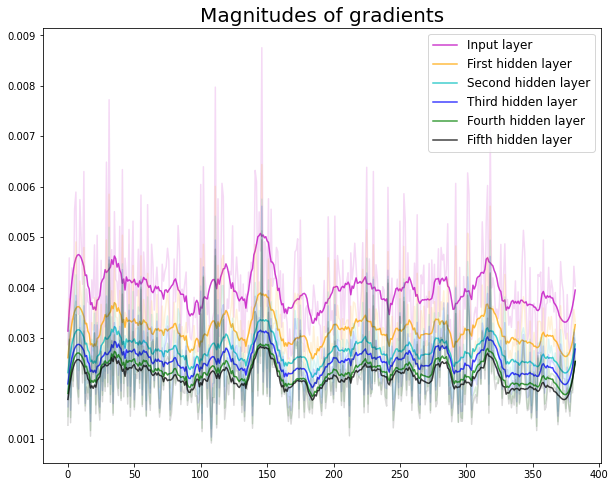

In [74]:
plt_gradients(_)


The Vanishing Gradient Problem seems to be solved.